# Chapter 1-2

After checking ROIs with "Suite2pROICuration",extract F traces of specific celltypes(Neuron, Astrocyte, etc.).   
In this notebook, you can extract the traces and export as csv file.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.io import loadmat
from scipy.stats import zscore
from typing import *

# dir_parent = os.path.dirname(os.path.dirname(os.getcwd()))
# if not dir_parent in sys.path:
#     sys.path.append(dir_parent)

# from optic.utils import *

# Save directory
dir_dst = "./result/Chapter1-2_ExtractTracesOfSpecificCelltypes"

In this notebook, compare WT group F data and 3q29 group data

In [101]:
# ROICuration.mat path
dict_path_roi_curation = {
    "WT": {
        "AQ01": "Z:/database/database_HfixWskVib/AQ01/250526/ROIcuration_AQ01-f1-z160_250526_1-spontaWsk_plane0.mat"
    },
    "3q29": {
        "AQ02": "Z:/database/database_HfixWskVib/AQ02/250527/ROIcuration_AQ02-f1-z160_250527_1-spontaWsk_plane0.mat"
    }
}

def loadROICurationAndFallMat(path_roi_curation: str) -> Tuple[Dict, np.ndarray]:
    # load ROIcuration.mat data
    roi_curation = loadmat(path_roi_curation, simplify_cells=True)

    path_fall = roi_curation["path_Fall"]
    roi_curation = roi_curation['manualROIcheck']
    date_save = list(roi_curation.keys())[-1]

    roi_curation = roi_curation[date_save]

    # load Fall.mat data
    fall = loadmat(path_fall, simplify_cells=True)
    return roi_curation, fall

def extractROIMedFromFallStatAndROICuration(fall_stat: List[Dict], roi_curation: Dict) -> np.ndarray:
    """
    Extract the median of the ROI from the FallStat data.
    """
    arr_med = np.array([fall_stat[i]["med"] for i in range(len(fall_stat))])
    arr_med = arr_med[:, ::-1]

    med_neuron = arr_med[roi_curation['Neuron']]
    med_astrocyte = arr_med[roi_curation['Astrocyte']]
    med_noise = arr_med[roi_curation['Not_Cell']]
    return med_neuron, med_astrocyte, med_noise

def loadTracesOfNeuronAstrocyteNoise(roi_curation: Dict, f: np.ndarray, verbose: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Extract traces of neurons, astrocytes, and noise from the ROI curation data.
    """
    # Extract neuron traces
    neuron_indices = roi_curation['Neuron']
    f_neuron = f[neuron_indices, :]

    # Extract astrocyte traces
    astrocyte_indices = roi_curation['Astrocyte']
    f_astrocyte = f[astrocyte_indices, :]

    # Extract noise traces
    noise_indices = roi_curation['Not_Cell']
    f_noise = f[noise_indices, :]

    if verbose:
        print("Neuron", f_neuron.shape)
        print("Astrocyte", f_astrocyte.shape)
        print("Not_Cell", f_noise.shape)

    return f_neuron, f_astrocyte, f_noise

In [102]:
group = "WT"

list_mouse_name = list(dict_path_roi_curation[group].keys())
mouse_name = list_mouse_name[0]
path_roi_curation = dict_path_roi_curation[group][mouse_name]

print("Load ROI curation data")
print(f"Group: {group}, Mouse: {mouse_name}, Path: {path_roi_curation}")
# Load ROI curation and extract cell types and traces
roi_curation, fall = loadROICurationAndFallMat(path_roi_curation)

# extract F of specific celltype
f_neuron, f_astrocyte, f_noise = loadTracesOfNeuronAstrocyteNoise(roi_curation, fall["F"])

# extract med of specific celltype
med_neuron, med_astrocyte, med_noise = extractROIMedFromFallStatAndROICuration(fall["stat"], roi_curation)

Load ROI curation data
Group: WT, Mouse: AQ01, Path: Z:/database/database_HfixWskVib/AQ01/250526/ROIcuration_AQ01-f1-z160_250526_1-spontaWsk_plane0.mat
Neuron (170, 5446)
Astrocyte (116, 5446)
Not_Cell (1466, 5446)


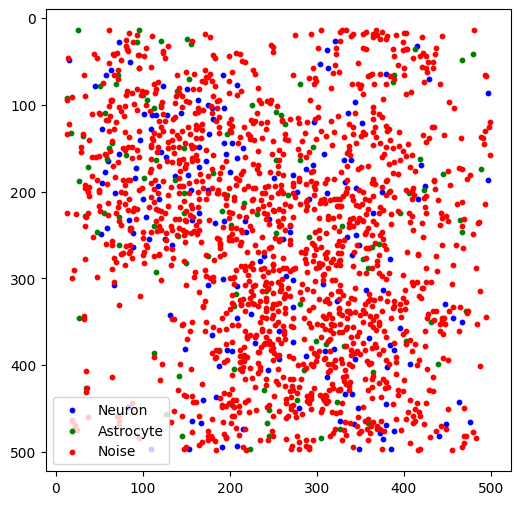

In [104]:
plt.figure(figsize=(6, 6))
plt.scatter(med_neuron[:, 0], med_neuron[:, 1], label="Neuron", color="blue", s=10)
plt.scatter(med_astrocyte[:, 0], med_astrocyte[:, 1], label="Astrocyte", color="green", s=10)
plt.scatter(med_noise[:, 0], med_noise[:, 1], label="Noise", color="red", s=10)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

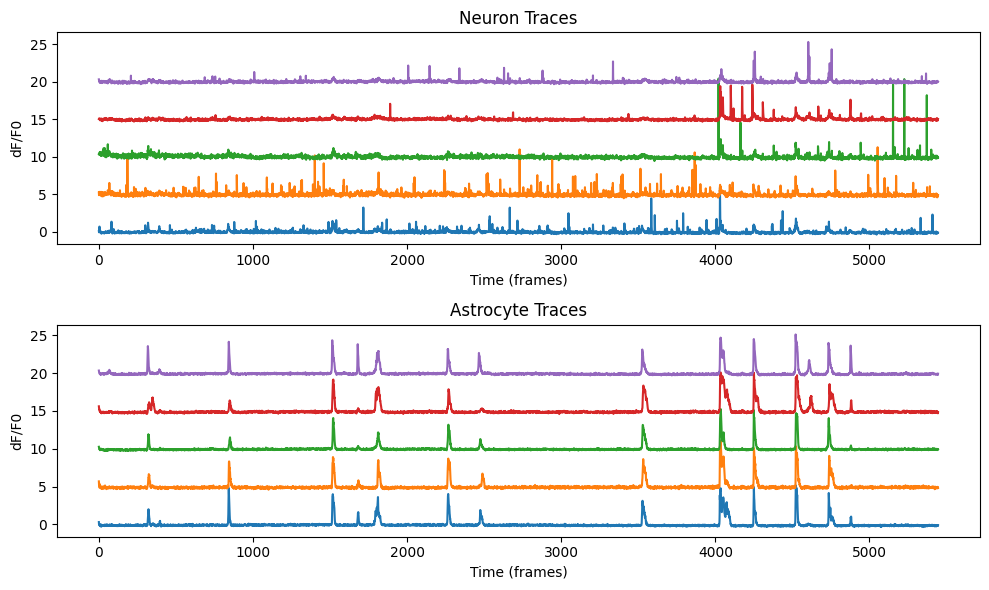

In [86]:
# plot traces

def plotTrace(
        f: np.ndarray, 
        idxs_f: List[int], 
        dff0_plot: bool = True,
        y_shift: int = 10,
        legend: bool = False,
        title: str = "",
        xlabel: str = "",
        ylabel: str = ""
        ) -> None:
    x = np.arange(f.shape[1])
    for i, idx in enumerate(idxs_f):
        y = f[idx]
        if dff0_plot:
            y = (y - np.mean(y)) / np.mean(y)
        plt.plot(x, y + i * y_shift, label=f"ROI {idx}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend()


figsize = (10, 6)
path_dst = f"{dir_dst}/{group}_{mouse_name}_traces.png"

idxs_plot_neuron = np.arange(0, 5)
idxs_plot_astrocyte = np.arange(0, 5)

plt.figure(figsize=figsize)
plt.subplot(2, 1, 1)
plotTrace(
    f_neuron, 
    idxs_plot_neuron, 
    dff0_plot=True, 
    y_shift=5, 
    legend=False, 
    title="Neuron Traces", 
    xlabel="Time (frames)", 
    ylabel="dF/F0"
)

plt.subplot(2, 1, 2)
plotTrace(
    f_astrocyte, 
    idxs_plot_astrocyte, 
    dff0_plot=True, 
    y_shift=5, 
    legend=False, 
    title="Astrocyte Traces", 
    xlabel="Time (frames)", 
    ylabel="dF/F0"
)
plt.tight_layout()
plt.savefig(path_dst, dpi=300)
plt.show()

In [87]:
# set percentile for dF/F0 calculation
percentile = 20

f0_neuron = np.percentile(f_neuron, q=percentile, axis=1)
f0_astrocyte = np.percentile(f_astrocyte, q=percentile, axis=1)

dff0_neuron = (f_neuron - f0_neuron[:, np.newaxis]) / f0_neuron[:, np.newaxis]
dff0_astrocyte = (f_astrocyte - f0_astrocyte[:, np.newaxis]) / f0_astrocyte[:, np.newaxis]

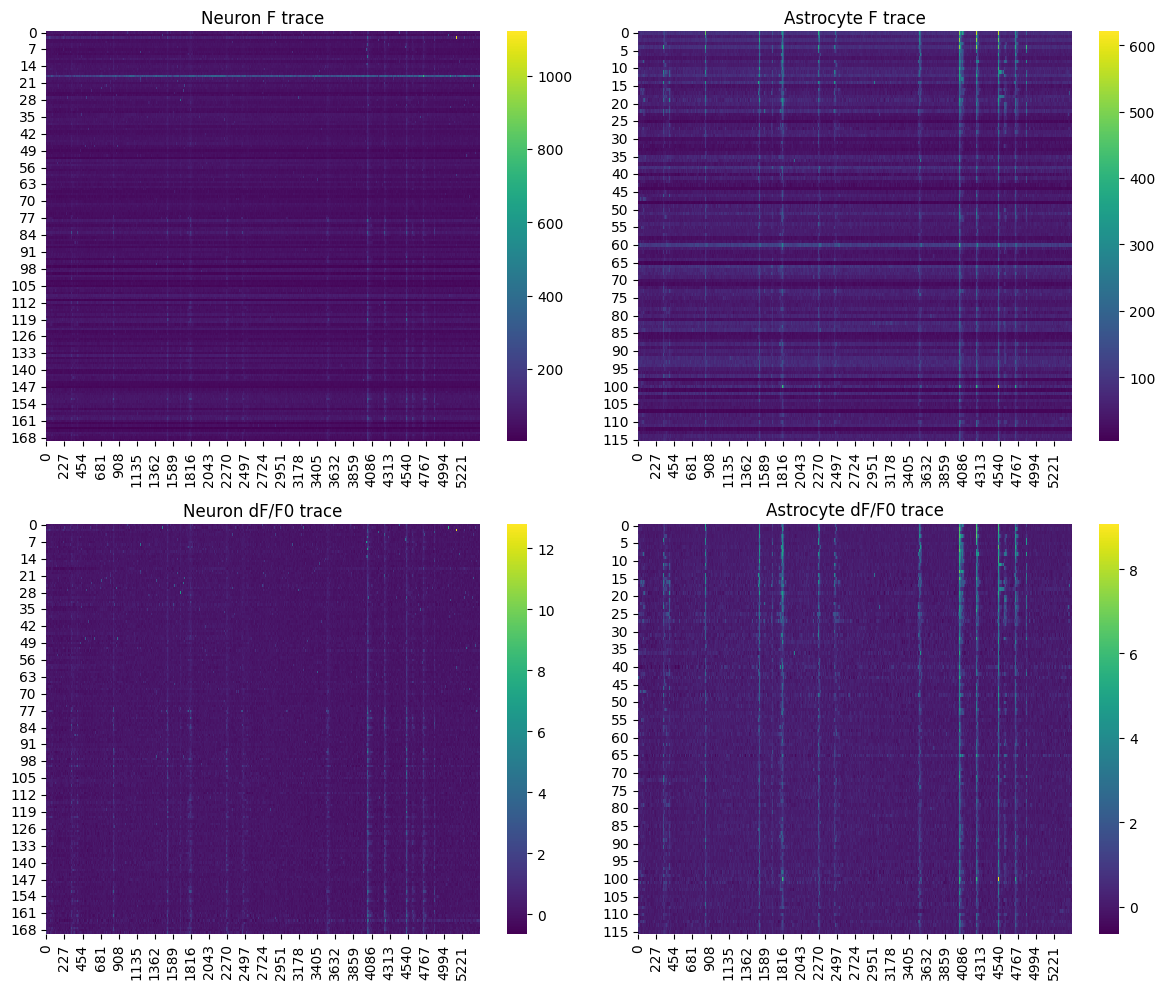

In [88]:
# F trace
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(f_neuron, cmap="viridis", cbar=True)
plt.title("Neuron F trace")

plt.subplot(2, 2, 2)
sns.heatmap(f_astrocyte, cmap="viridis", cbar=True)
plt.title("Astrocyte F trace")
# dff0 trace

plt.subplot(2, 2, 3)
sns.heatmap(dff0_neuron, cmap="viridis", cbar=True)
plt.title("Neuron dF/F0 trace")

plt.subplot(2, 2, 4)
sns.heatmap(dff0_astrocyte, cmap="viridis", cbar=True)
plt.title("Astrocyte dF/F0 trace")
plt.tight_layout()

plt.show()

In [89]:
# calculate AUC of dF/F0 trace

# split frames into segments
n_segments = 10

def calculateAUC(dff0: np.ndarray, n_segments: int) -> np.ndarray:
    n_rois, n_frames = dff0.shape
    segment_length = n_frames // n_segments
    auc_values = np.zeros((n_rois, n_segments))
    dff0_over0 = dff0.copy()
    dff0_over0[dff0_over0 < 0] = 0  # Set negative values to zero

    for i in range(n_segments):
        start = i * segment_length
        end = (i + 1) * segment_length if i < n_segments - 1 else n_frames
        auc_values[:, i] = np.sum(dff0_over0[:, start:end], axis=1)

    return auc_values

auc_neuron = calculateAUC(dff0_neuron, n_segments)
auc_astrocyte = calculateAUC(dff0_astrocyte, n_segments)

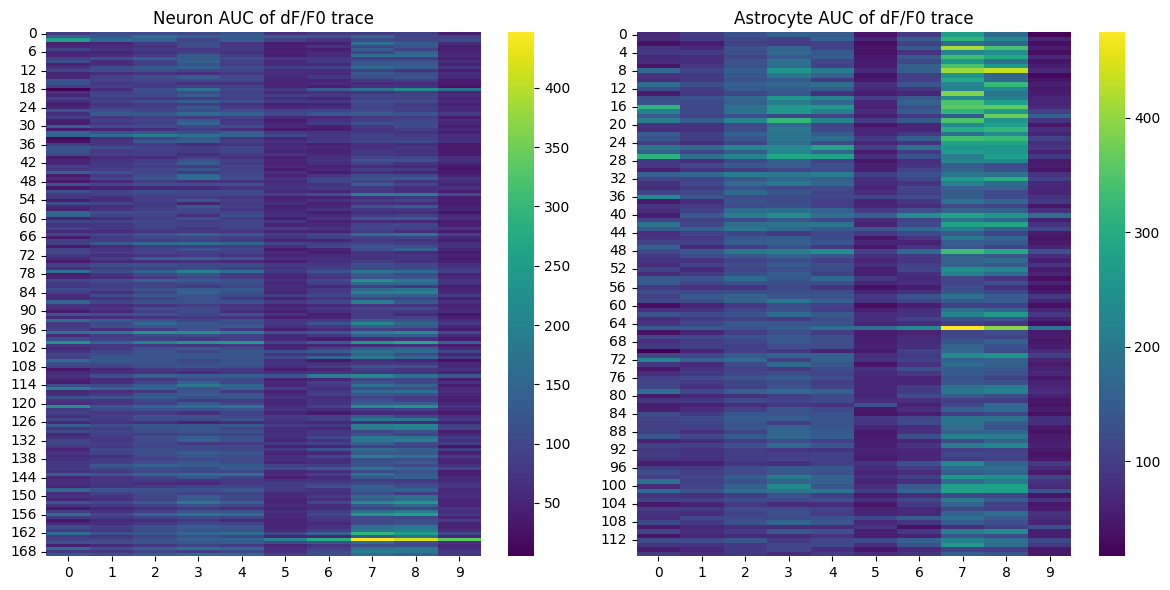

In [90]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(auc_neuron, cmap="viridis", cbar=True)
plt.title("Neuron AUC of dF/F0 trace")
plt.subplot(1, 2, 2)
sns.heatmap(auc_astrocyte, cmap="viridis", cbar=True)
plt.title("Astrocyte AUC of dF/F0 trace")
plt.tight_layout()
plt.show()

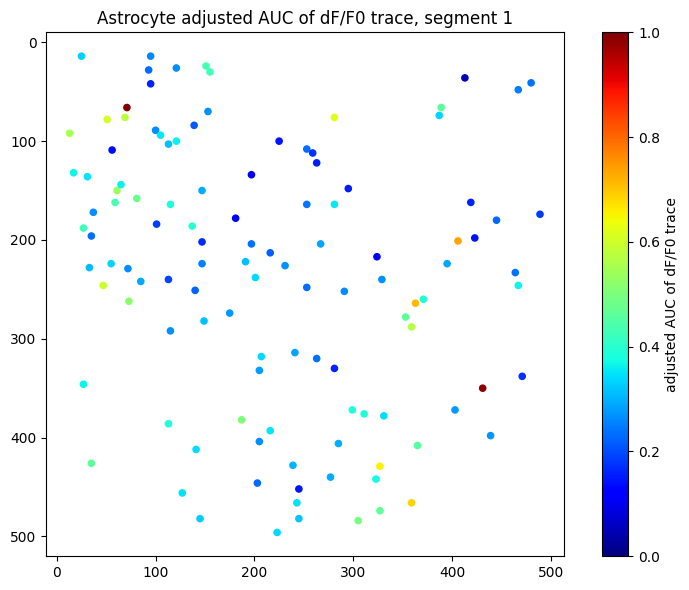

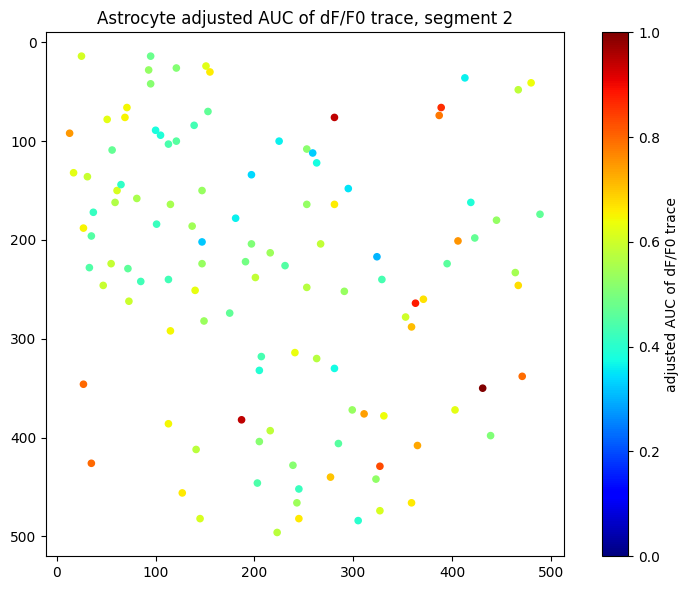

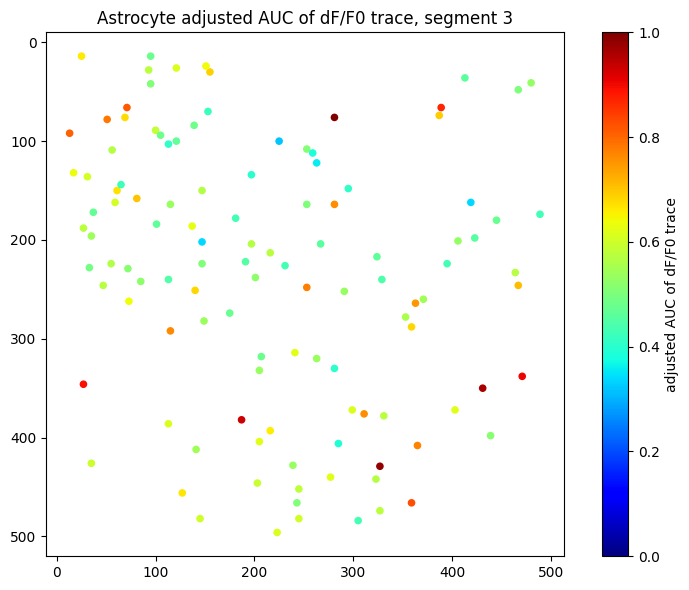

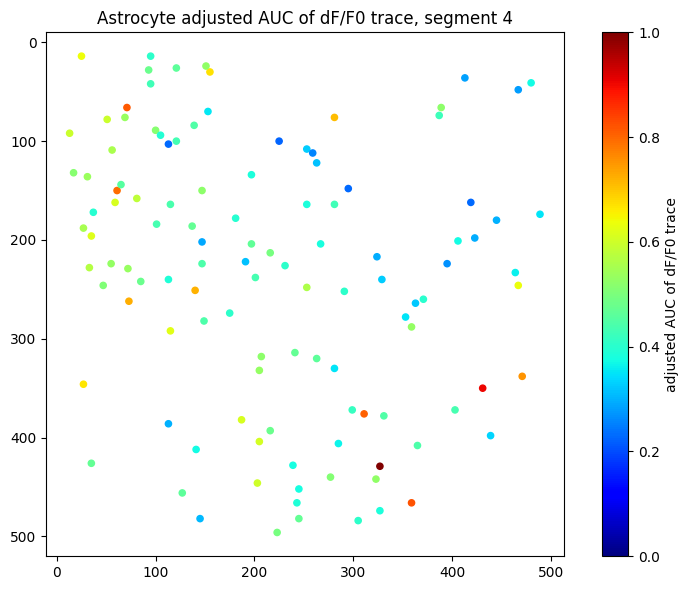

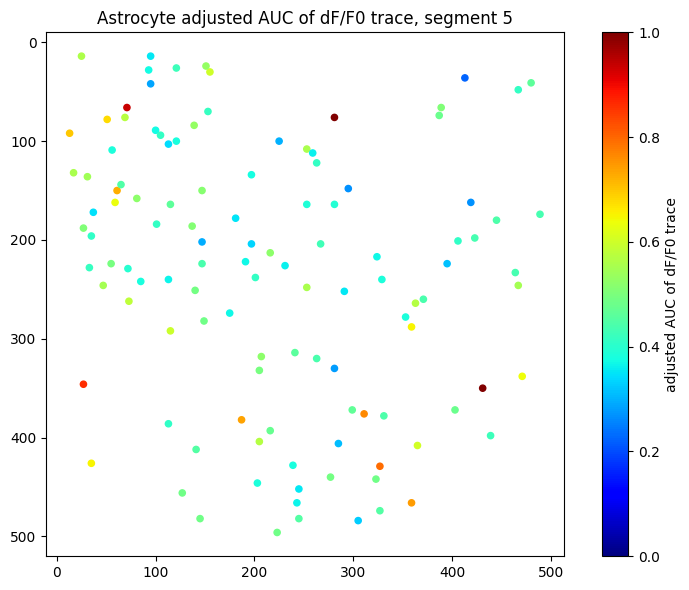

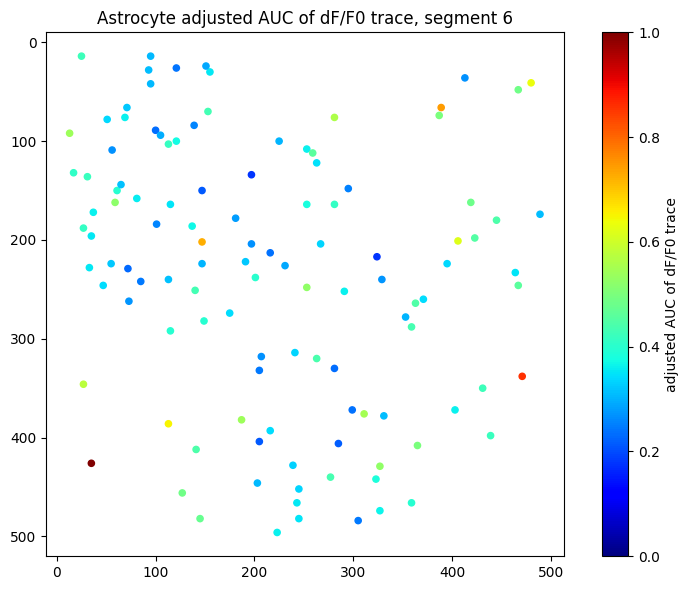

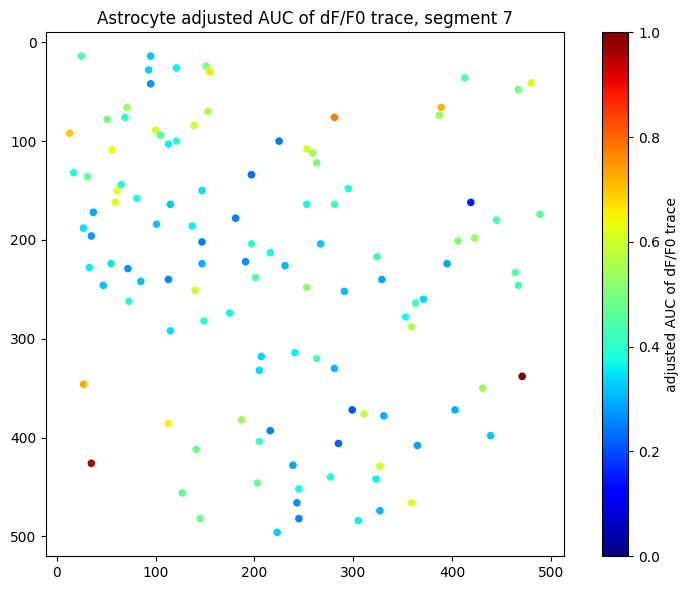

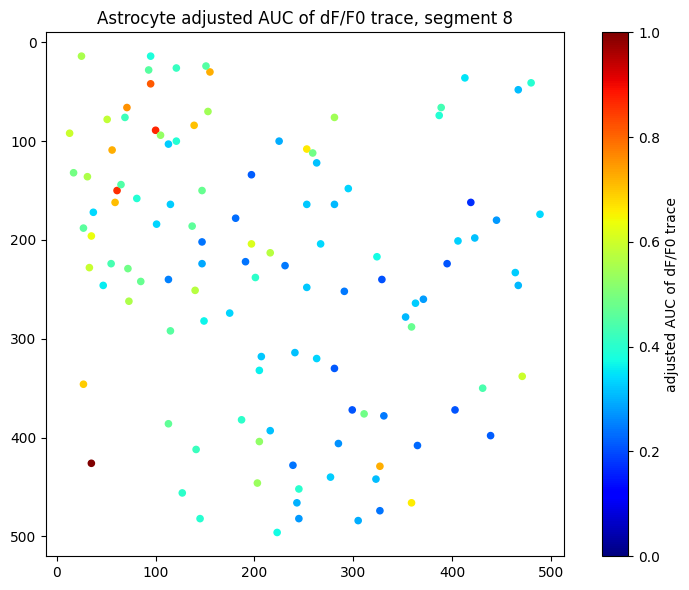

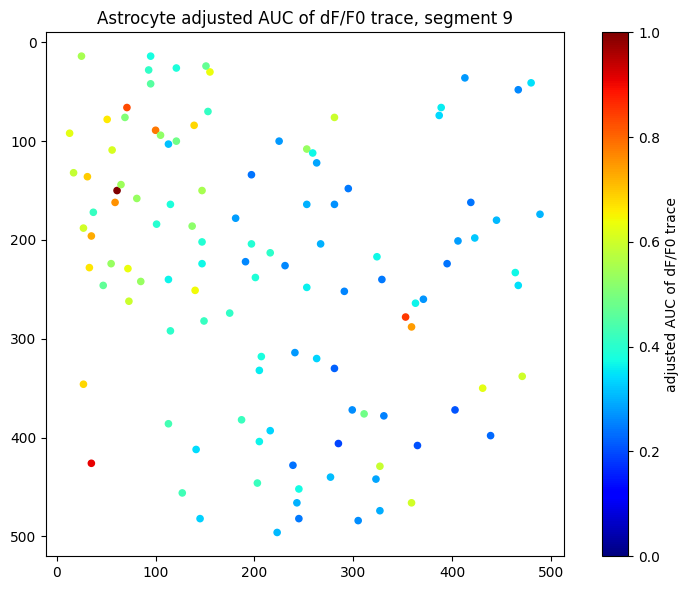

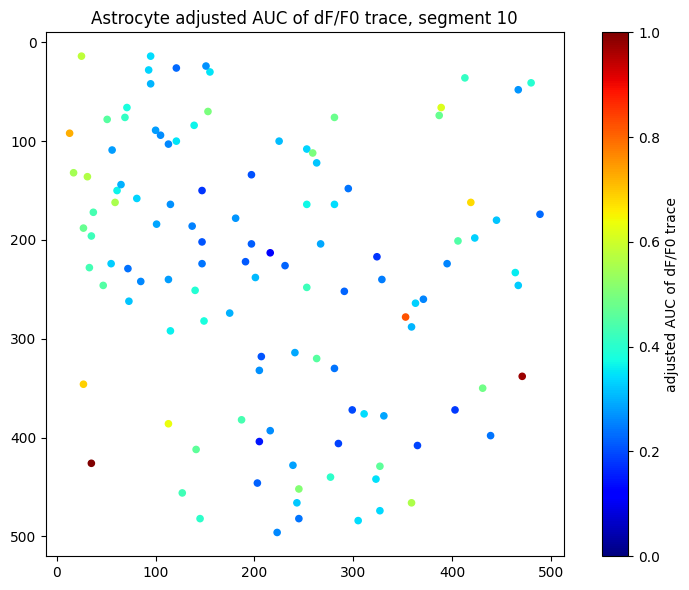

In [105]:
for i in range(n_segments):
    plt.figure(figsize=(8, 6))
    color_max = np.max(auc_astrocyte[:, i])
    colors = auc_astrocyte[:, i] / color_max  # Normalize colors for better visualization
    plt.scatter(med_astrocyte[:, 0], med_astrocyte[:, 1], label="Astrocyte", cmap="jet", c=colors, s=20, vmin=0, vmax=1)
    plt.title(f"Astrocyte adjusted AUC of dF/F0 trace, segment {i + 1}")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().invert_yaxis()
    plt.colorbar(label="adjusted AUC of dF/F0 trace")
    plt.tight_layout()
    plt.show()

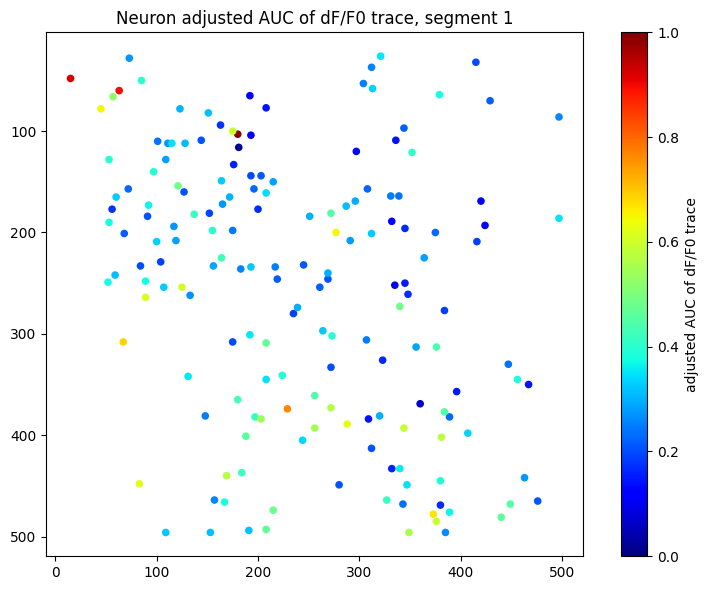

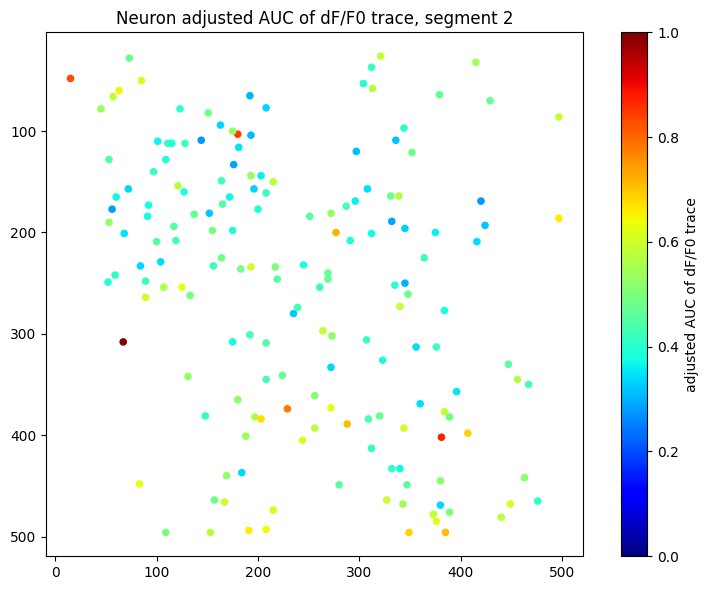

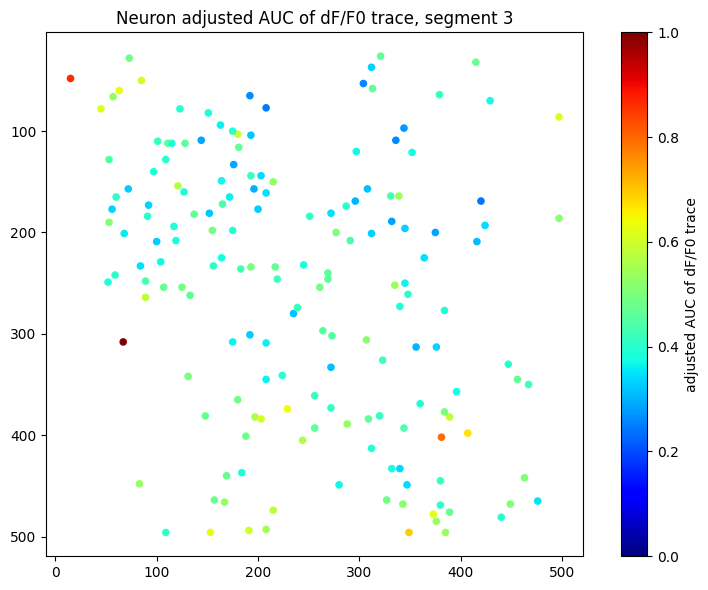

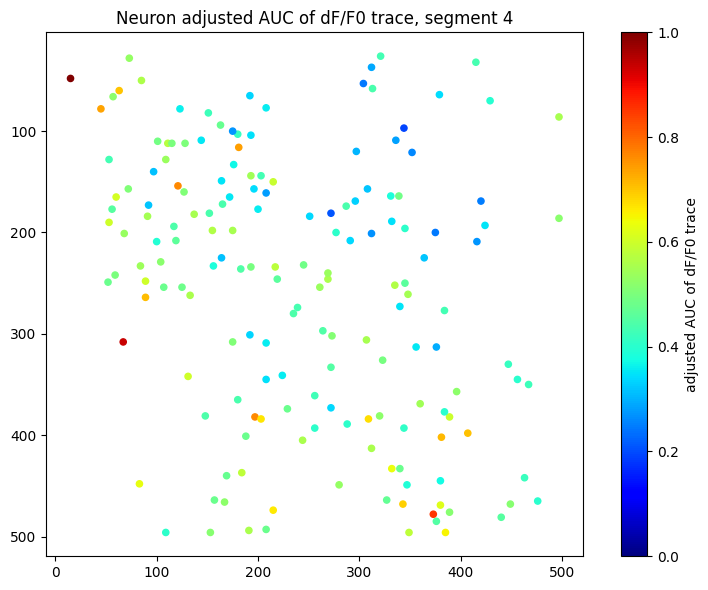

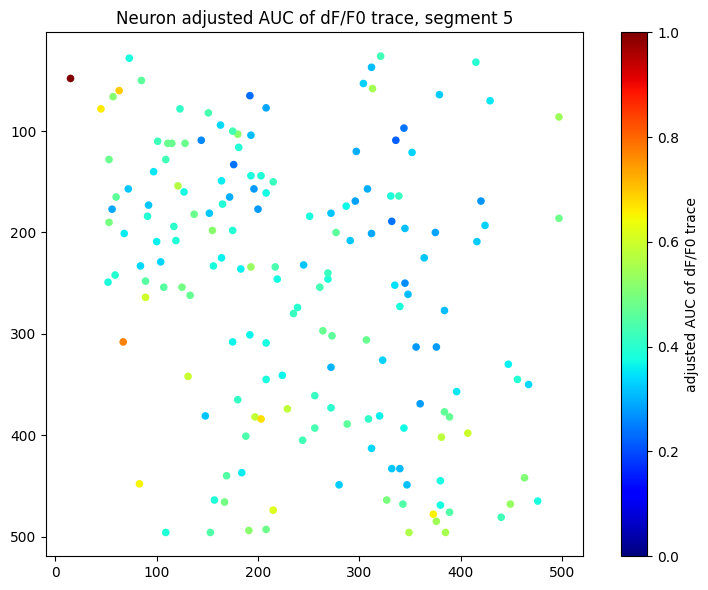

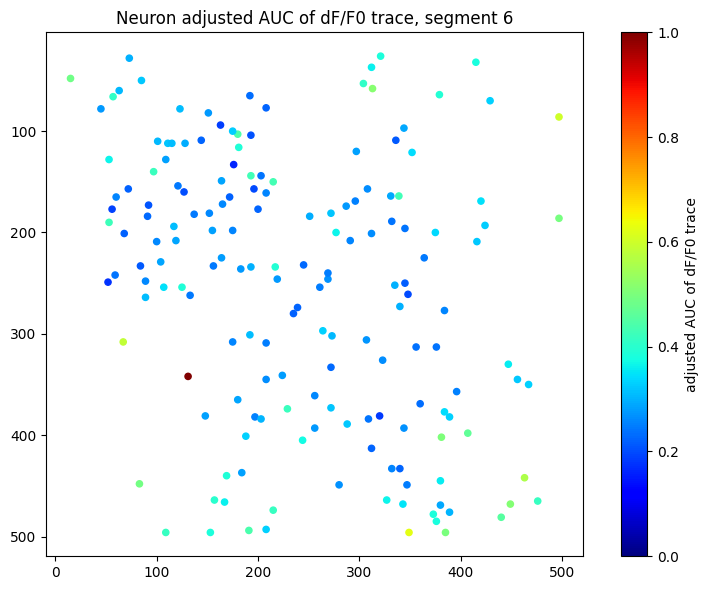

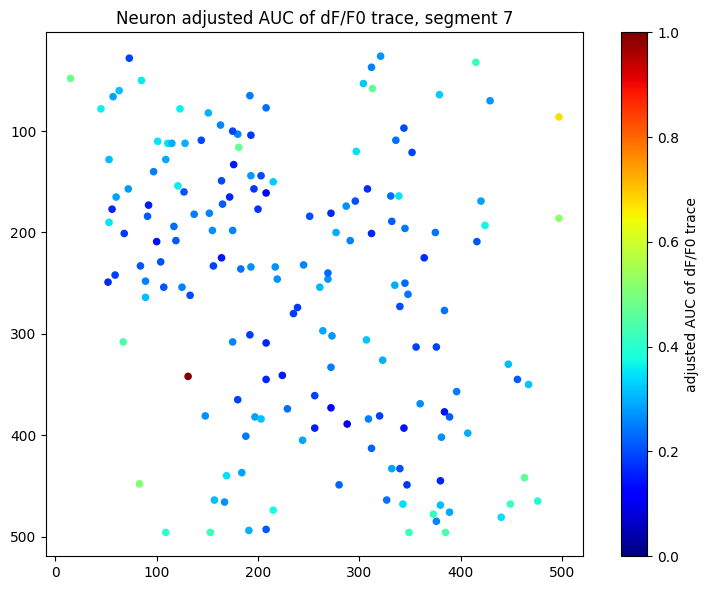

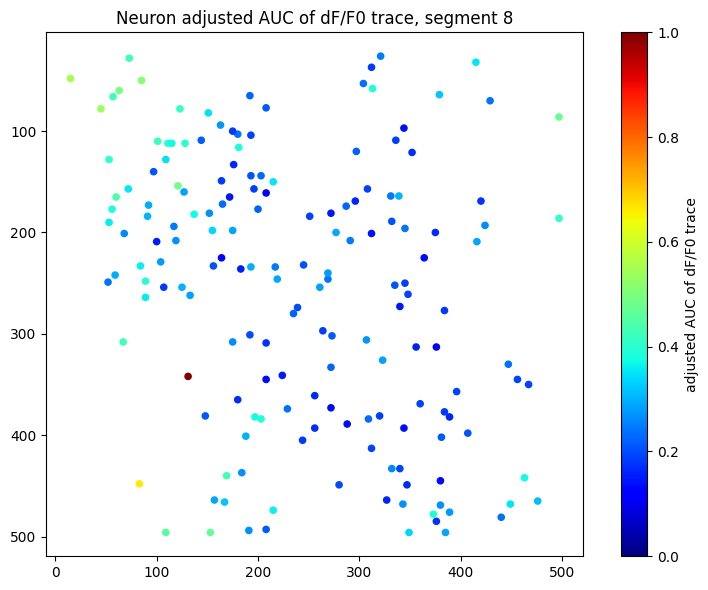

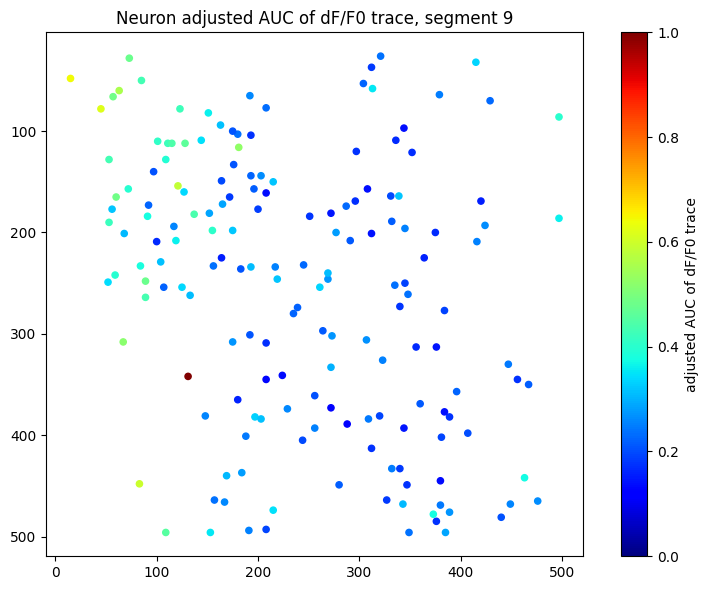

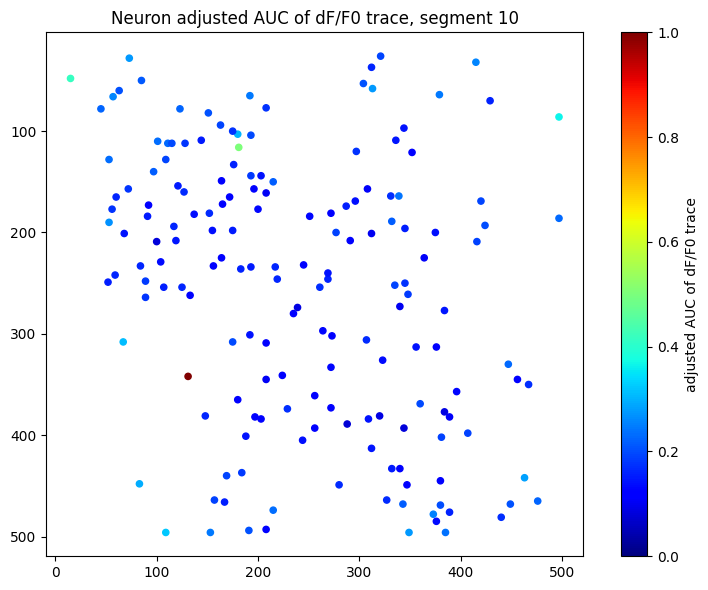

In [106]:
for i in range(n_segments):
    plt.figure(figsize=(8, 6))
    color_max = np.max(auc_neuron[:, i])
    colors = auc_neuron[:, i] / color_max  # Normalize colors for better visualization
    plt.scatter(med_neuron[:, 0], med_neuron[:, 1], label="Neuron", cmap="jet", c=colors, s=20, vmin=0, vmax=1)
    plt.title(f"Neuron adjusted AUC of dF/F0 trace, segment {i + 1}")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().invert_yaxis()
    plt.colorbar(label="adjusted AUC of dF/F0 trace")
    plt.tight_layout()
    plt.show()